$$HAMI: \ Hippocampal-Augmented \ Memory \ Integration$$

# Imports

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from gym import spaces
from collections import deque
from collections import namedtuple
import torch.nn.functional as F
import pandas as pd
from google.colab import files
from collections import namedtuple, deque
from tqdm import tqdm
import time
import sys

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Generation

In [ ]:
# Define the transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the four distinctive colors (R, G, B values)
colors = {
    "blue": [25, 50, 100],
    "red": [225, 75, 25],
    "green": [50, 100, 75],
    "yellow": [175, 150, 50]
}


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 44.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.37MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.7MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.69MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def colorize_mnist(images, color):
    colorized_images = []
    for img in images:

        img_colored = torch.zeros((3, 28, 28))   # Create an RGB image with black background

        # Change the background color
        for i in range(3):
            img_colored[i, :, :] = 1- ((1 - img)* (1-(color[i]/255)))
        colorized_images.append(img_colored)

    return colorized_images


# Organize the data by digit categories
def organize_by_digit_category(data, labels):
    organized_data = {i: [] for i in range(10)}
    for img, label in zip(data, labels):
        organized_data[int(label)].append(img)
    return organized_data


In [ ]:
# Colorize the MNIST dataset
colored_mnist = {}
for color_name, color_value in colors.items():
    colored_mnist[color_name] = {
        "train": colorize_mnist((mnist_train.data/255), color_value),
        "test": colorize_mnist((mnist_test.data/255), color_value)
    }

# Organize the data by digit categories
CMNIST = {}
for color_name in colors.keys():
    CMNIST[color_name] = {
        "train": organize_by_digit_category(colored_mnist[color_name]["train"], mnist_train.targets),
        "test": organize_by_digit_category(colored_mnist[color_name]["test"], mnist_test.targets)
    }

# Functions

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Environment

In [ ]:
random.seed(369)
class SequenceEnvironment(gym.Env):
    def __init__(self, data, seq_length=3, out_of_seq_prob=0.4, mode='train'):
        super(SequenceEnvironment, self).__init__()
        self.mode = mode
        self.data = data
        self.seq_length = seq_length
        self.out_of_seq_prob = out_of_seq_prob
        self.colors = ['blue', 'red', 'green', 'yellow']

        # Action space: Predict "In Sequence" or "Out of Sequence"
        self.action_space = spaces.Discrete(2)

        # Observation space: The current image
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 28, 28), dtype=np.float32)

        self.log = {
            'sequence': [],
            'actions': [],
            'rewards': []
        }

        self.reset()

    def reset(self):

        self.color = random.choices(self.colors,[8,8,3,3])[0]
        self.current_sequence = self._generate_sequence(self.color)
        self.current_index = 0
        self.done = False
        self.log = {
            'sequence': self.current_sequence,
            'actions': [],
            'rewards': []
        }
        return self.current_sequence[self.current_index]

    def step(self, action):
        reward = 0

        self.correct_action = self._check_correct_action()

        if action == self.correct_action:
            reward = 0.5 * (self.current_index+1)
            self.current_index += 1
            if self.current_index >= self.seq_length:
                self.done = True
        else:
            reward = -1
            self.done = True

        next_state = self.current_sequence[self.current_index] if not self.done else None



        # Log the action and reward
        self.log['actions'].append(action)
        self.log['rewards'].append(reward)


        return next_state, reward, self.done, {}

    def _generate_sequence(self, color):
        if color == 'blue':
            start = random.randint(0, 7)
            sequence = [start, start + 1, start + 2]
        elif color == 'red':
            start = random.randint(2, 9)
            sequence = [start, start - 1, start - 2]
        elif color == 'green':
            start = random.choice([0, 2, 4])
            sequence = [start, start + 2, start + 4]
        elif color == 'yellow':
            start = random.choice([1, 3, 5])
            sequence = [start, start + 2, start + 4]
        self.correct_seq = sequence

        images = []
        self.observed_seq = []
        for i, num in enumerate(sequence):
            if i > 0 and random.random() < self.out_of_seq_prob:
                num = random.randint(0, 9)
            image = random.choice(self.data[color][self.mode][num])
            images.append(image)
            self.observed_seq.append(num)


        return images

    def _check_correct_action(self):
        correct_number = self.correct_seq[self.current_index]
        observed_number = self.observed_seq[self.current_index]
        return int(correct_number == observed_number)

    def render(self, mode='human'):
        fig, axs = plt.subplots(1, self.seq_length, figsize=(15, 5))
        for i, image in enumerate(self.log['sequence']):
            axs[i].imshow(image.permute(1, 2, 0).numpy())
            axs[i].axis('off')
            if i < len(self.log['actions']):
                action = 'InSeq' if self.log['actions'][i] == 1 else 'OutSeq'
                axs[i].set_title(f"Action: {action}\nReward: {self.log['rewards'][i]}")

        plt.show()



Action: 1, Reward: 0.5, Done: False
Action: 0, Reward: 1.0, Done: False
Action: 1, Reward: 1.5, Done: True
Total Reward: 3.0


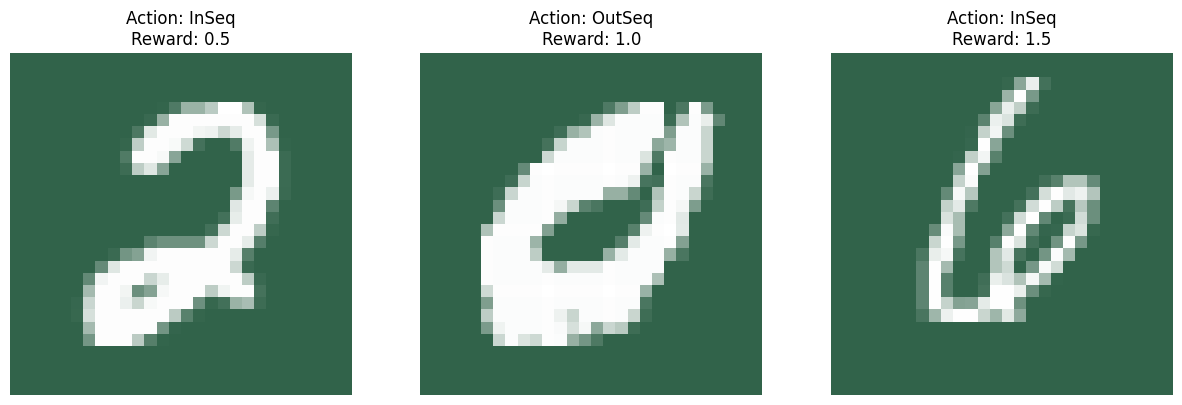

In [ ]:
# Example
env = SequenceEnvironment(CMNIST)
total_reward = 0

done = False
while not done:
    action = env.action_space.sample()  # Random action for testing
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    print(f"Action: {action}, Reward: {reward}, Done: {done}")

print(f"Total Reward: {total_reward}")
env.render()  # Visualize the episode

# Pretext

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )



    def forward(self, x1, x2):
        out1 = self.conv_layers(x1)
        out2 = self.conv_layers(x2)
        out1 = self.fc_layers(out1.view(out1.size(0), -1))
        out2 = self.fc_layers(out2.view(out2.size(0), -1))
        return out1, out2

    def extract_features(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x.view(x.size(0), -1))
        return x

    def extract_conv_layers(self):
        return self.conv_layers


In [ ]:
color_emb = SiameseNetwork()
color_emb.load_state_dict(torch.load("contrastive_model_color"))
color_emb.eval()
digit_emb = SiameseNetwork()
digit_emb.load_state_dict(torch.load("contrastive_model_digit"))
digit_emb.eval()

<ipython-input-13-03473d92c61b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  color_emb.load_state_dict(torch.load("contrastive_model_color"))
<ipython-input-13-03473d92c

SiameseNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
)

# HAMI

In [ ]:
# Define MemoryEntry as a namedtuple
MemoryEntry = namedtuple('MemoryEntry', ['context_event_indices', 'action', 'episode_reward'])

class IndexTable:
    """Table to manage context and event indices based on feature vector similarity."""
    def __init__(self, similarity_threshold=0.9):
        self.table = {}
        self.index_counter = np.uint8(1)  # Start from 1, 0 is reserved for null states
        self.similarity_threshold = similarity_threshold

    def _similarity(self, vec1, vec2):
        """Compute cosine similarity between two vectors."""
        return F.cosine_similarity(vec1, vec2, dim=0)

    def get_or_create_index(self, vector, enforce_threshold=True):
        """Return index for the most similar vector above threshold or assign a new one if none exist."""
        best_similarity = -1.0
        best_index = None

        for stored_vector, idx in self.table.items():
            similarity = self._similarity(vector, stored_vector).item()

            # Update if similarity is above threshold and higher than previous best
            if similarity >= (self.similarity_threshold if enforce_threshold else 0) and similarity > best_similarity:
                best_similarity = similarity
                best_index = idx

        # Use the best match if found, otherwise assign a new index
        if best_index is not None:
            return best_index

        # Assign a new index if no suitable match was found
        self.table[vector] = self.index_counter
        new_index = self.index_counter
        self.index_counter = np.uint8(self.index_counter + 1)  # Increment and ensure it stays as uint8
        return new_index


class Hippocampus:
    def __init__(self, color_emb, digit_emb, capacity=3000, window_size=3, knn=1, context_thr=0.9, event_thr=0.9):
        self.color_emb = color_emb.eval()
        self.digit_emb = digit_emb.eval()
        self.memory = deque(maxlen=capacity)
        self.window_size = window_size
        self.knn = knn
        self.context_table = IndexTable(similarity_threshold=context_thr)
        self.event_table = IndexTable(similarity_threshold=event_thr)
        self.count_similar = 0
        self.count_replace = 0
        self.total_steps = 0

    def extract_indices(self, sequence, enforce_threshold=True):
        """Extract indices from feature vectors of contexts and events in a sequence."""
        with torch.no_grad():
            colors = self.color_emb.extract_features(torch.stack(sequence, dim=0))
            digits = self.digit_emb.extract_features(torch.stack(sequence, dim=0))

        colors = colors.detach()  # Detach the tensor from the computation graph
        digits = digits.detach()  # Detach the tensor from the computation graph

        context_indices = [self.context_table.get_or_create_index(c, enforce_threshold) for c in colors]
        event_indices = [self.event_table.get_or_create_index(d, enforce_threshold) for d in digits]

        return context_indices, event_indices



    def store_memory(self, env_log, replace_mask, index_list):
        episode_length = len(env_log['actions'])
        rewards = env_log['rewards']
        sequence = env_log['sequence']

        context_indices, event_indices = self.extract_indices(sequence, enforce_threshold=True)
        episode_rewards = [sum(rewards[i:]) for i in range(episode_length)]

        for i in range(episode_length):
            context_event_window = self.create_windows(i, context_indices, event_indices)

            memory_entry = MemoryEntry(
                context_event_indices=context_event_window,
                action=env_log['actions'][i],
                episode_reward=episode_rewards[i]
            )
            if replace_mask[i]:
                self.count_similar += 1
                if self.memory[index_list[i]].episode_reward < episode_rewards[i]:
                    self.memory[index_list[i]] = memory_entry  # Replace memory entry with new one if higher reward
                    self.count_replace += 1
            else:
                self.memory.append(memory_entry)

    def create_windows(self, i, context_indices, event_indices):
        """Create context-event windows with previous, current, and next indices."""
        if i == 0:
            context_event_window = [(np.uint8(0), np.uint8(0)), (np.uint8(0), np.uint8(0)), (context_indices[i], event_indices[i])]
        elif i == 1:
            context_event_window = [(np.uint8(0), np.uint8(0)), (context_indices[i - 1], event_indices[i - 1]),
                                    (context_indices[i], event_indices[i])]
        else:
            context_event_window = [(context_indices[i - 2], event_indices[i - 2]),
                                    (context_indices[i - 1], event_indices[i - 1]),
                                    (context_indices[i], event_indices[i])]
        return context_event_window

    def memory_batch(self):
        """Return a batch of memory entries."""
        return MemoryEntry(*zip(*self.memory))

    def working_memory(self, env, enforce_threshold=True):
        """Retrieve current working memory indices with padded previous states."""
        current_index = env.current_index
        current_sequence = env.current_sequence
        context_indices, event_indices = self.extract_indices(current_sequence[:current_index + 1], enforce_threshold)

        wm_context = [np.uint8(0)] * (self.window_size - 1 - current_index) + context_indices
        wm_event = [np.uint8(0)] * (self.window_size - 1 - current_index) + event_indices
        working_memory = [(wm_context[i], wm_event[i]) for i in range(self.window_size)]
        return working_memory

    def _similarity_score(self, wm_entry, mem_entry):
        """Compute similarity between working memory and episodic memory entry."""
        similarity = sum(1 if wm_entry[i] == mem_entry[i] else 0 for i in range(self.window_size))
        return similarity / self.window_size  # Similarity as fraction of matching pairs

    def memory_lookup(self, working_memory):
        """Find the most similar memory entry based on context-event indices."""
        similarities = [self._similarity_score(working_memory, mem_entry.context_event_indices)
                        for mem_entry in self.memory]
        return torch.tensor(similarities)

    def Avg_KNN(self, working_memory):
        """Retrieve the best action based on k-nearest neighbors."""
        if len(self.memory) == 0:
            return {0: -1, 1: -1}, {0: None, 1: None}, {0: 0, 1: 0}

        similarity_scores = self.memory_lookup(working_memory)
        memory_batch = self.memory_batch()
        actions = torch.tensor(memory_batch.action)
        rewards = torch.tensor(memory_batch.episode_reward)

        action_rewards = {}
        memory_index = {}
        action_similarity = {}

        for action in range(2):
            action_indices = torch.where(actions == action)[0]
            if len(action_indices) > 0:
                action_similarities = similarity_scores[action_indices]
                top_k_values, top_k_indices = torch.topk(action_similarities, self.knn)
                nearest_neighbor = action_indices[top_k_indices[0]]
                avg_reward = rewards[nearest_neighbor].float().item()

                action_rewards[action] = avg_reward
                memory_index[action] = nearest_neighbor.item()
                action_similarity[action] = top_k_values[0].item()
            else:
                action_rewards[action] = -1.0
                memory_index[action] = None
                action_similarity[action] = 0.0

        return action_rewards, memory_index, action_similarity


    def train(self, env, num_episodes, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        epsilon = epsilon_start
        episode_rewards = []

        for episode in tqdm(range(num_episodes)):
            state = env.reset()
            done = False
            episode_reward = 0
            replace_mask = []
            index_list = []

            while not done:
                working_memory = self.working_memory(env)
                action_rewards, memory_index, action_similarity = self.Avg_KNN(working_memory)

                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = max(action_rewards, key=action_rewards.get)


                if action_similarity[action] < 1.0:  # Only replace if not an exact match
                    replace_mask.append(False)
                else:
                    replace_mask.append(True)
                index_list.append(memory_index[action])

                next_state, reward, done, _ = env.step(action)
                episode_reward += reward

                self.total_steps += 1


            self.store_memory(env.log, replace_mask, index_list)
            epsilon = max(epsilon_end, epsilon * epsilon_decay)
            episode_rewards.append(episode_reward)

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}, Avg Reward: {sum(episode_rewards[-100:]) / 100:.2f}, Epsilon: {epsilon:.2f}")

        return episode_rewards

    def test(self, env, num_episodes):
        total_rewards = []
        correct_actions = 0
        total_actions = 0

        for episode in tqdm(range(num_episodes)):
            state = env.reset()
            done = False
            episode_reward = 0

            while not done:
                working_memory = self.working_memory(env, enforce_threshold=False)
                action_rewards, _, _ = self.Avg_KNN(working_memory)
                action = max(action_rewards, key=action_rewards.get)

                next_state, reward, done, info = env.step(action)
                episode_reward += reward

                if action == env.correct_action:
                    correct_actions += 1
                total_actions += 1

            total_rewards.append(episode_reward)

        avg_reward = torch.tensor(total_rewards).mean().item()
        avg_accuracy = correct_actions / total_actions

        return avg_reward, avg_accuracy, total_rewards, correct_actions, total_actions


# Sample Experiment

In [ ]:
hip = Hippocampus(color_emb, digit_emb, capacity=1000, context_thr=0.9, event_thr=0.7)
train_env = SequenceEnvironment(CMNIST, mode='train')

start_time = time.time()
train_rewards = hip.train(train_env, num_episodes=1000,epsilon_decay=0.999)
end_time = time.time()
print(f"Total Training time is {end_time-start_time: .4f} seconds")

 11%|█         | 107/1000 [00:01<00:16, 54.09it/s]

Episode 100, Avg Reward: 0.15, Epsilon: 0.90


 21%|██        | 209/1000 [00:04<00:15, 52.40it/s]

Episode 200, Avg Reward: -0.10, Epsilon: 0.82


 31%|███▏      | 314/1000 [00:06<00:08, 82.75it/s]

Episode 300, Avg Reward: 0.23, Epsilon: 0.74


 41%|████      | 406/1000 [00:07<00:08, 68.14it/s]

Episode 400, Avg Reward: 0.17, Epsilon: 0.67


 51%|█████     | 512/1000 [00:08<00:07, 61.50it/s]

Episode 500, Avg Reward: 0.35, Epsilon: 0.61


 61%|██████    | 609/1000 [00:10<00:06, 59.45it/s]

Episode 600, Avg Reward: 0.69, Epsilon: 0.55


 71%|███████   | 706/1000 [00:12<00:04, 61.32it/s]

Episode 700, Avg Reward: 0.55, Epsilon: 0.50


 80%|████████  | 801/1000 [00:15<00:12, 16.12it/s]

Episode 800, Avg Reward: 1.00, Epsilon: 0.45


 90%|█████████ | 903/1000 [00:19<00:02, 32.44it/s]

Episode 900, Avg Reward: 0.99, Epsilon: 0.41


100%|██████████| 1000/1000 [00:22<00:00, 44.56it/s]

Episode 1000, Avg Reward: 1.38, Epsilon: 0.37
Total Training time is  22.4482 seconds


In [ ]:
print(f"Number of Context Symbols: {len(hip.context_table.table)}")
print(f"Number of Event Symbols: {len(hip.event_table.table)}")
print('--------------------------------------------------')
print(f"Similar Episodic Memories ran into: {hip.count_similar}")
print(f"Number of Episodic Memory Entries Replaced: {hip.count_replace}")
print('--------------------------------------------------')
print(f"Total Steps during Training: {hip.total_steps}")
print(f"Occupied Memory: {len(hip.memory)}")

Number of Context Symbols: 4
Number of Event Symbols: 11
--------------------------------------------------
Similar Episodic Memories ran into: 1590
Number of Episodic Memory Entries Replaced: 36
--------------------------------------------------
Total Steps during Training: 2151
Occupied Memory: 561


In [ ]:
# Testing
test_env = SequenceEnvironment(CMNIST, mode='test')

start_time = time.time()
avg_reward, avg_accuracy, total_rewards, correct_actions, total_actions = hip.test(test_env, num_episodes=1000)
end_time = time.time()

print('--------------------------------------------------')
print(f"Average Reward: {avg_reward:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print('--------------------------------------------------')
print(f"correct_actions: {correct_actions}")
print(f"total_actions: {total_actions}")

print('--------------------------------------------------')
print(f"Total inference time is {end_time-start_time: .4f} seconds")
print('--------------------------------------------------')
pd.Series(total_rewards).value_counts()

100%|██████████| 1000/1000 [00:18<00:00, 55.47it/s]

--------------------------------------------------
Average Reward: 2.3295
Average Accuracy: 0.9228
--------------------------------------------------
correct_actions: 2664
total_actions: 2887
--------------------------------------------------
Total inference time is  18.0336 seconds
--------------------------------------------------


,count
3.0,777
-0.5,113
0.5,110
